In [1]:
import os;import sys
import pandas as pd;import numpy as np;from itertools import combinations, permutations, product
from datetime import datetime;from datetime import date
from collections import Counter;import matplotlib ; from matplotlib import pyplot as plt
import networkx as nx; from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from scipy.io import loadmat
from scipy.sparse import csr_matrix
from scipy import stats
from sknetwork.clustering import Louvain, BiLouvain, modularity, bimodularity
import nbimporter ; import importlib as imp ; from scipy.optimize import minimize 
from scipy.optimize import LinearConstraint
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import (confusion_matrix,  
                           accuracy_score) 
  
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from random import gauss, random, choices
import pickle; import math
import geopandas as gpd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from scipy.stats.distributions import chi2


In [2]:
import statsmodels.api as sm 

In [3]:
path=os.getcwd()

In [4]:
def flatten(L):
    return [l for ll in L for l in ll]

In [5]:
def partition(l, nbin):
    dw = int(np.ceil(len(l)/nbin))
    ll = []
    i0 = 0
    while i0+dw<len(l):
        ll.append(l[i0:i0+dw])
        i0+=dw
    if i0 < len(l):
        ll[-1] = ll[-1]+l[i0:]
    return ll

<h2 style='text-align: center;'> Import Model Data </h2>

In [6]:
indicator_df = pd.read_csv('./../indicators/indicator_df.csv')
indicator_df = indicator_df.rename(columns={'Unnamed: 0': 'Country','Unnamed: 1':'Indicator'})
indicator_df = indicator_df.set_index(['Country','Indicator'])

In [7]:
data = pd.read_csv('./../indicators/model_data_bonds_loans_df.csv')

In [8]:
countries = [
         'India',
         'Mexico',
         'Brazil',
         'South Africa',
         'Indonesia',
         'Thailand',
        ]

In [9]:
data = data[(data.Country.apply(lambda x: x in countries))
           &(data.Corporate==1)]

In [10]:
data['FCY']=data.LCY.apply(lambda x: 1 if x==0 else 0)

<h2 style='text-align: center;'> Results </h2>

In [11]:
mdl = data.copy();len(mdl)

1112

<h3 style='text-align: left;'> One-hot Country encoding </h2>

In [12]:
# Create a DataFrame with the one-hot encoded columns
# Drop first column to avoid the dummy variable trap
one_hot_df = pd.get_dummies(mdl.Country, drop_first=True)
mdl = pd.concat([mdl, one_hot_df], axis=1)

<h3 style='text-align: left;'> One-hot Tenor encoding </h2>

In [13]:
one_hot_df = pd.get_dummies(mdl.Tenor_bracket)

In [14]:
one_hot_df=one_hot_df.rename(columns = {'0-5 yrs':'tenor_1',
                    '5-10 yrs': 'tenor_2',
                    '>10 yrs': 'tenor_3',
                             } )

In [15]:
mdl = pd.concat([mdl, one_hot_df], axis=1)

In [16]:
mdl['Amount'] = mdl['Amount'].apply(lambda x: np.log(x))

In [17]:
FE_country_ = ['India','Indonesia','Mexico','South Africa','Thailand']
FE_tenor_ = ['tenor_{}'.format(i) for i in [1,2,3]] 

In [18]:
vars_cntrl_ = ['Amount','Domestic','Bond',
              'GDP Growth','Tenor']

In [19]:
all_vars_ = ['FX_short','Ratings FC','VIX','Pol_Risk']\
            + vars_cntrl_ \
            + FE_country_ 

In [20]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [21]:
log_reg = sm.Logit(mdl.FCY, mdl[all_vars_]).fit(maxiter=100)

Optimization terminated successfully.
         Current function value: 0.352281
         Iterations 8


In [22]:
log_reg.prsquared

0.4145873915627709

<h3 style='text-align: left;'> Scenarios </h3>

##### Change VIX 

In [23]:
for c in countries:
    VIX = indicator_df.loc[c,'VIX'].values
    indicator_df.loc[(c,'VIX_min'),:] = [0]*len((VIX))

##### Change FX 

In [24]:
for c in countries:
    FX = indicator_df.loc[c,'FX_short'].values
    indicator_df.loc[(c,'FX_short_min'),:] = [min(FX)]*len(FX)

##### Change Ratings 

In [25]:
mean_vals_low = mdl[all_vars_].mean()
mean_vals_high = mdl[all_vars_].mean()

In [26]:
mean_vals_low['Ratings FC']=5;
mean_vals_high['Ratings FC']=13

In [27]:
log_reg.predict(mean_vals_low).values[0],\
log_reg.predict(mean_vals_high).values[0]

(0.03197951056104472, 0.31690268754551315)

#### Baseline model

In [29]:
years = range(2004,2024)

In [30]:
mdl_base = mdl.copy()
y_prob = log_reg.predict(mdl_base[all_vars_])
y_pred = [0 if p<0.5 else 1 for p in y_prob]
mdl_base.FCY = y_pred
LCY_base = [mdl_base[(mdl_base.Year==y) &
            (mdl_base.FCY==0)].Amount.apply(
            lambda x: np.exp(x)).sum() for y in years]
FCY_base = [mdl_base[(mdl_base.Year==y) &
            (mdl_base.FCY==1)].Amount.apply(
            lambda x: np.exp(x)).sum() for y in years]

In [31]:
LCY_true = [mdl[(mdl.Year==y) &
                    (mdl.FCY==0)].Amount.apply(
            lambda x: np.exp(x)).sum() for y in years]
FCY_true = [mdl[(mdl.Year==y) &
                         (mdl.FCY==1)].Amount.apply(
            lambda x: np.exp(x)).sum() for y in years]

In [32]:
years = range(2004,2024)

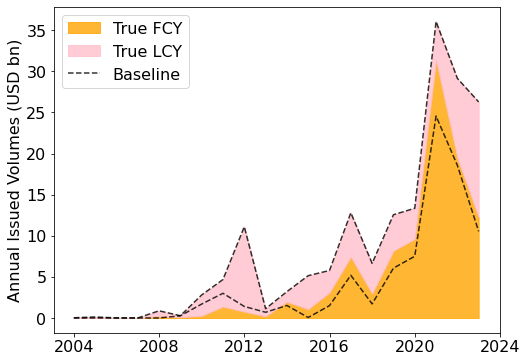

In [64]:
fig, ax = plt.subplots(1, 1, figsize = (8,6))
fs = 16
a=0.8

ax.fill_between(years,
                np.array(FCY_true),
                color='orange',
                label='True FCY',
                alpha=0.8
               )


ax.fill_between(years,
                np.array(LCY_true)+np.array(FCY_true),
                np.array(FCY_true),
                color='pink',
                label='True LCY',
                alpha=0.8
               )
ax.plot(years,
       FCY_base,
       color='black',
         #label='Baseline',
       alpha = 0.8,
        linestyle='--'
       )
ax.plot(years,
       np.array(FCY_base)+np.array(LCY_base),
       color='black',
         label='Baseline',
        linestyle='--',
       alpha = 0.8,
       )

"""ax2 = ax.twinx()
ax2.plot(np.arange(2020,2024,.25),
        indicator_df.loc['Brazil','VIX'][['Q{}-{}'.format(q,y)
                                 for y in range(2020,2024)
                                 for q in range(1,5)]])""";


ax.legend(fontsize=fs,loc='upper left')
ax.set_ylabel('Annual Issued Volumes (USD bn)', fontsize=fs)
ax.tick_params(labelsize=fs);
ax.set_xticks(np.arange(2004,2028,4));
ax.set_xticklabels([int(y) for y in ax.get_xticks()],fontsize=fs);
fig.savefig('./../figs/fig_S4.png',dpi=800)

#### Scenario Analysis: FX & VIX

In [33]:
mdl_scenario, LCY_scenario, FCY_scenario = {}, {}, {}

In [34]:
# Create new variable dataframes holding VIX and FX_short at minimum levels
for var_, new_var_ in [('VIX', 'VIX_min'),
                      ('FX_short', 'FX_short_min')]:
    mdl_scenario[var_] = mdl.copy()
    mdl_scenario[var_][var_] = \
        mdl_scenario[var_][['Year','Quarter']].apply(
    lambda x: indicator_df.loc[c,new_var_][[
                        'Q{}-{}'.format(x[1],x[0])]][0] ,
                axis=1)

In [35]:
# Use fitted model to predict LCY/FCY with VIX_min and FX_short_min scenario
for var_, new_var_ in [('VIX', 'VIX_min'),
                      ('FX_short', 'FX_short_min')]:

    y_prob = log_reg.predict(mdl_scenario[var_][all_vars_])
    y_pred = [0 if p<0.5 else 1 for p in y_prob]
    mdl_scenario[var_].FCY = y_pred

    LCY_scenario[var_] = [mdl_scenario[var_][(mdl_scenario[var_].Year==y) &
                    (mdl_scenario[var_].FCY==0)].Amount.apply(
            lambda x: np.exp(x)).sum()
                            for y in years]
    FCY_scenario[var_] = [mdl_scenario[var_][(mdl_scenario[var_].Year==y) &
                (mdl_scenario[var_].FCY==1)].Amount.apply(
            lambda x: np.exp(x)).sum()
                            for y in years]

In [36]:
# Create dataframes to store debt holdings in each quarter
quarters = ['Q{}-{}'.format(Q,Y) for Y in years \
            for Q in range(1,5)]
df = pd.DataFrame(0, 
                 columns = quarters,
                 index = countries)

dollar_debt_df = {'base':df.copy(),'VIX':df.copy(),
                 'true':df.copy(),'FX':df.copy()}

In [37]:
# Calculate foreign debt holdings in each scenario and baseline
for data, var_ in [(mdl_scenario['VIX'],'VIX'),(mdl_scenario['FX_short'],'FX'),
                   (mdl_base,'base'), (mdl,'true')]:
    for i, row in data.iterrows():
        q_maturity = int(row.Tenor)*4
        amount = np.exp(row.Amount)
        country = row.Country
        Q0 = 'Q{}-{}'.format(row.Quarter, row.Year)
        if (row.FCY == 1) & (Q0 in quarters): 
            Q0_index = quarters.index(Q0)
            for q in range(Q0_index, Q0_index + q_maturity):
                dollar_debt_df[var_].loc[country,
                                         quarters[q]] += \
                        amount
                if q+1==len(quarters): break

In [38]:
true_FCY=[dollar_debt_df['true'][['Q{}-{}'.format(q,y) for q 
                       in range(1,5)]].sum(axis=1)[0]
 for y in range(2004,2024)]

In [39]:
VIX_FCY=[dollar_debt_df['VIX'][['Q{}-{}'.format(q,y) for q 
                       in range(1,5)]].sum(axis=1)[0]
 for y in range(2004,2024)]

In [40]:
base_FCY=[dollar_debt_df['base'][['Q{}-{}'.format(q,y) for q 
                       in range(1,5)]].sum(axis=1)[0]
 for y in range(2004,2024)]

In [41]:
FX_FCY=[dollar_debt_df['FX'][['Q{}-{}'.format(q,y) for q 
                       in range(1,5)]].sum(axis=1)[0]
 for y in range(2004,2024)]

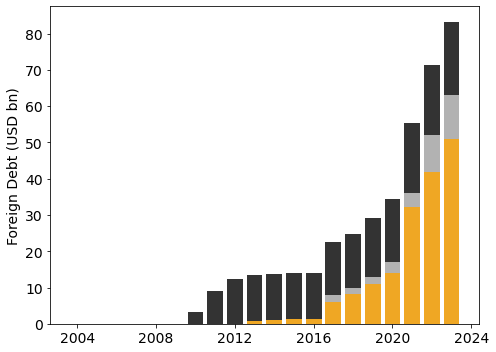

In [42]:
nrow, ncol = 1,1
fig, ax = plt.subplots(nrow, ncol, figsize=(7,5))
fs, a = 14, 0.8
ax.bar(years,
       base_FCY,
       color='black',
       alpha=a,
       label = 'base',
      )
ax.bar(years,
       FX_FCY,
       color='lightgray',
       alpha=a,
      label = 'FX_min')
ax.bar(years,
       VIX_FCY,
       color='orange',
       alpha=a,
      label = 'VIX_min')
ax.set_xticks(np.arange(2004,2028,4))
ax.set_xticklabels(np.arange(2004,2028,4), fontsize=fs)
ax.tick_params(axis='both', labelsize=fs)
ax.set_ylabel('Foreign Debt (USD bn)',fontsize=fs)
#ax.legend(fontsize=fs)
plt.tight_layout()
fig.savefig('./../figs/fig_4a.png',dpi=300)